# Data Pre-processing and Modeling

## Table of Contents
  * 1. [Import Libraries and Load Data](#load_data)
  * 2. [Data Pre-processing and Feature Engineering](#pre-processing)
    * 2.1 [Reshape Data and Eliminate Zero-only Features](#reshape)
    * 2.2 [Distribution of Features](#feature_distributions)
    * 2.3 [Normalize Data](#normalize)
    * 2.4 [Training Data Setup](#training_data)
  * 3. [Time Series Classification](#tsc)
    * 3.1 [Traditional Approaches](#traditional)
    * 3.2 [Recent Deep Learning-based Approaches](#deep_learning) 
  * 4. [Modeling](#modeling)
    * 4.1 [LSTM Timeseries Classifier](#lstm)
    * 4.2 [CNN/ResNet Timeseries Classifier](#cnn)
      * 4.2.1 [Network Size](#cnn_network_size)
      * 4.2.2 [Training Hyperparameter Tuning](#cnn_hyperparameters)
    * 4.3 [Transformer Timeseries Classifier](#transformer)
      * 4.3.1 [Training Hyperparameter Tuning](#encoder_hyperparameters)
      * 4.3.2 [Embeddings](#embeddings)
      * 4.3.3 [Multi-headed Self-attention Mechanisms](#self-attention)
      * 4.3.4 [Feed Forward and Residual Connections](#ff_res)
      * 4.3.5 [Drop-out Rate](#encoder_dropout)
      * 4.3.6 [Feature Importance](#encoder_feature_importance)
  * 5. [Results](#results)
      * 5.1 [Evaulation Metrics](#metrics)
      * 5.2 [Performance Comparison of Models](#comparisons)
  * 6. [Conclusion](#conclusion)

## 1 Import libraries and Load data<a id='load_data'></a>

In [1]:
import numpy as np
import math, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context(context="talk")

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
features = np.loadtxt('FordChallenge_X.csv', delimiter=',')
labels = np.loadtxt('FordChallenge_y.csv', delimiter=',')
features.shape

(36257, 1200)

## 2. Data pre-processing<a id='pre-processing'></a> 

### 2.1 Reshape data and Eliminate zero-only features<a id='reshape'></a> 

In [3]:
features = features.reshape(-1, 30,40)
features = np.transpose(features, (0, 2, 1))
# remove P7, V6 and V8 (7, 25, 27)
features=np.delete(features, [7,25,27], axis=2)

In [4]:
names_p =['P'+str(i) for i in range(7)]
names_e = ['E'+str(i) for i in range(11)]
names_v = ['V'+str(i) for i in range(11)]
names_v.remove('V6')
names_v.remove('V8')
names = names_p + names_e + names_v
print(names)

['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'E0', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10']


### 2.2 Distribution of Features<a id='feature_distributions'></a> 

In [5]:
features = features[:20000]
labels= labels[:20000]
mins = np.empty(features.shape[2])
maxes = np.empty(features.shape[2])

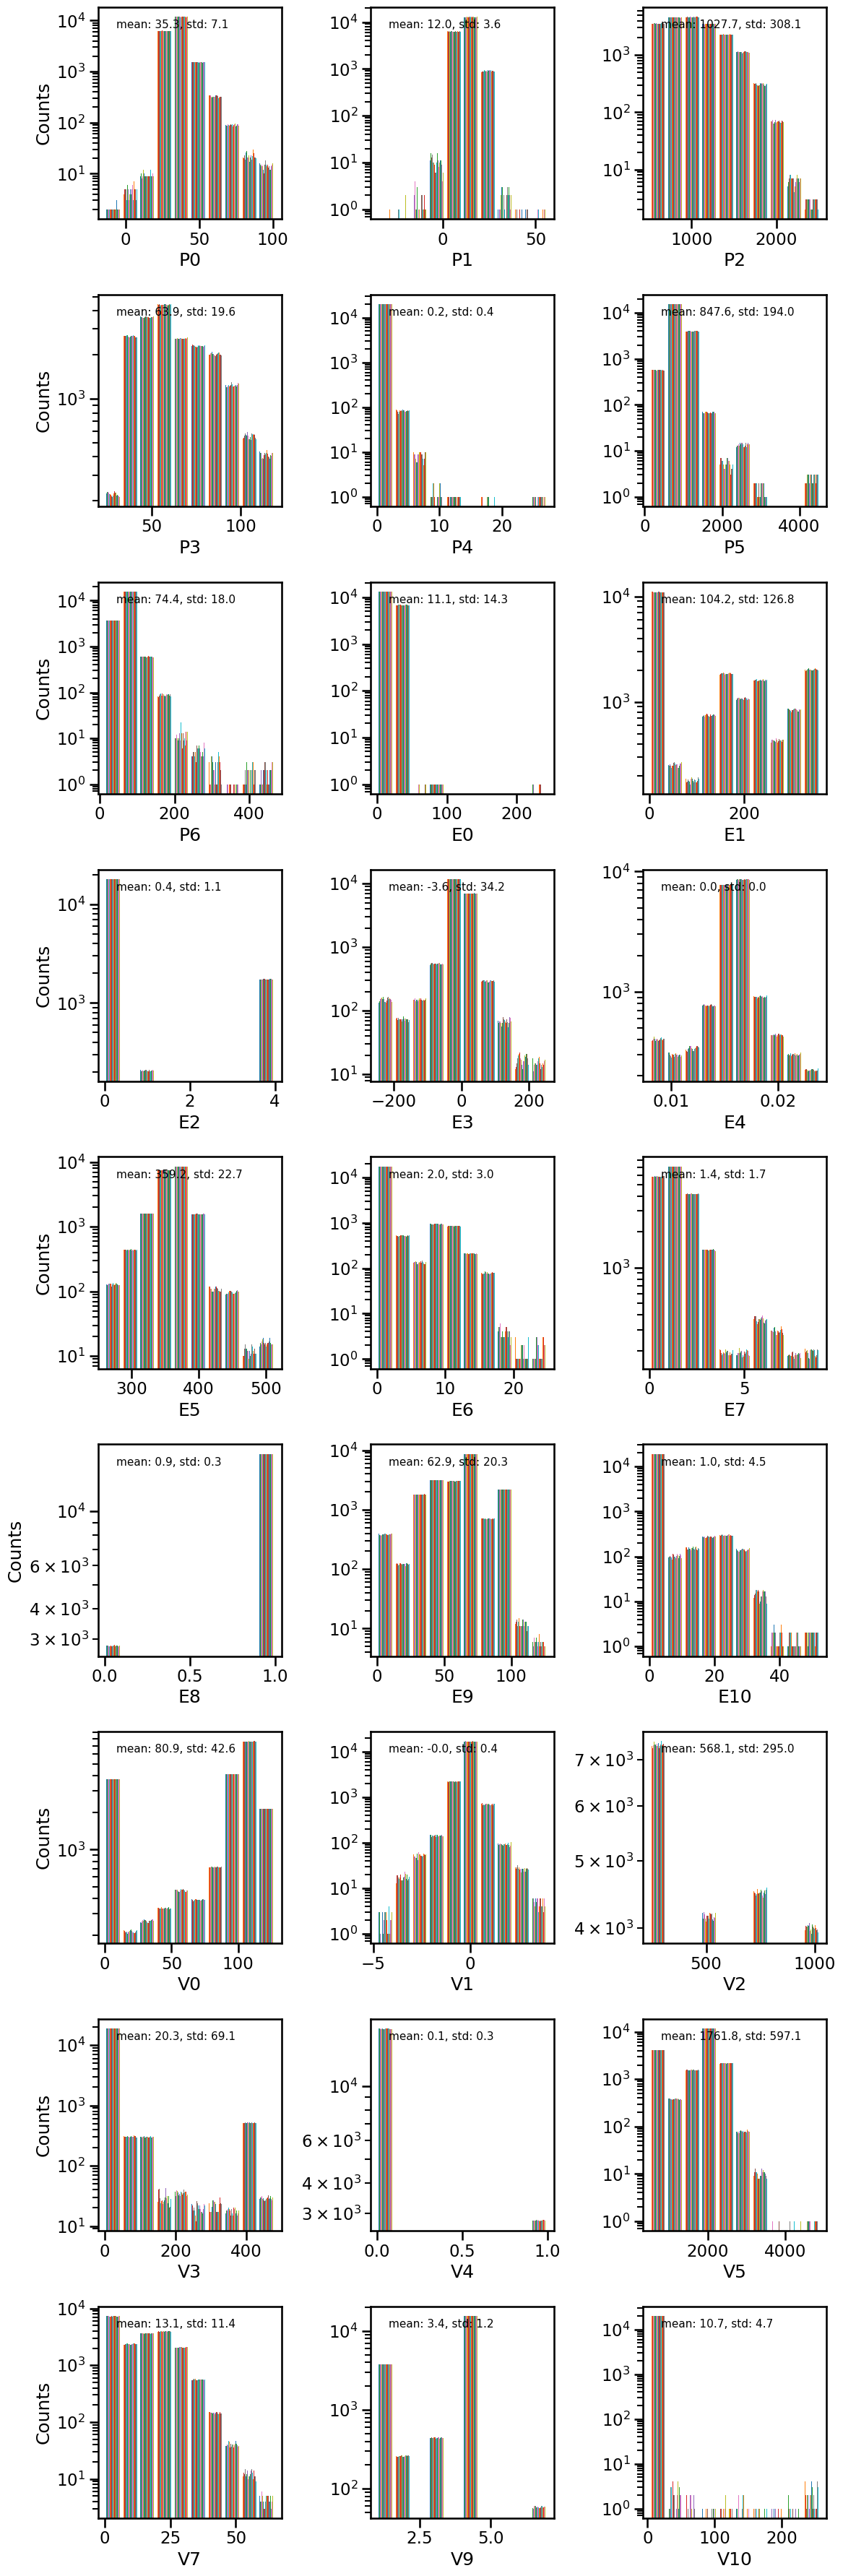

In [6]:
fig, axes = plt.subplots(9,3,figsize=(12,4*9))  
axes = axes.flatten()

for i, ax in enumerate(axes):
    x= features[:,:,i]
    ax.hist(x=x)
    ax.set_yscale('log')
    ax.set_xlabel(names[i])
    if i%3 ==0:
        ax.set_ylabel('Counts')

    mean, std = np.mean(x), np.std(x)
    mins[i] = np.min(x)
    maxes[i] = np.max(x)
    
    #print(mean, std)
    ax.text(0.1, 0.9, f"mean: {mean:.1f}, std: {std:.1f}", 
            fontsize=11, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('feature_dist.png')
plt.show()

# P5(5) >50000 
# E0(8) >100 
#ind_outlier = np.where(features[:,8,:]>100)
#ind_outlier

### 2.3 Normalize data<a id='normalize'></a> 

In [7]:
norm_features = features
for i in range(features.shape[2]):
    norm_features[:,:,i] = (features[:,:,i] - mins[i])/(maxes[i]-mins[i])

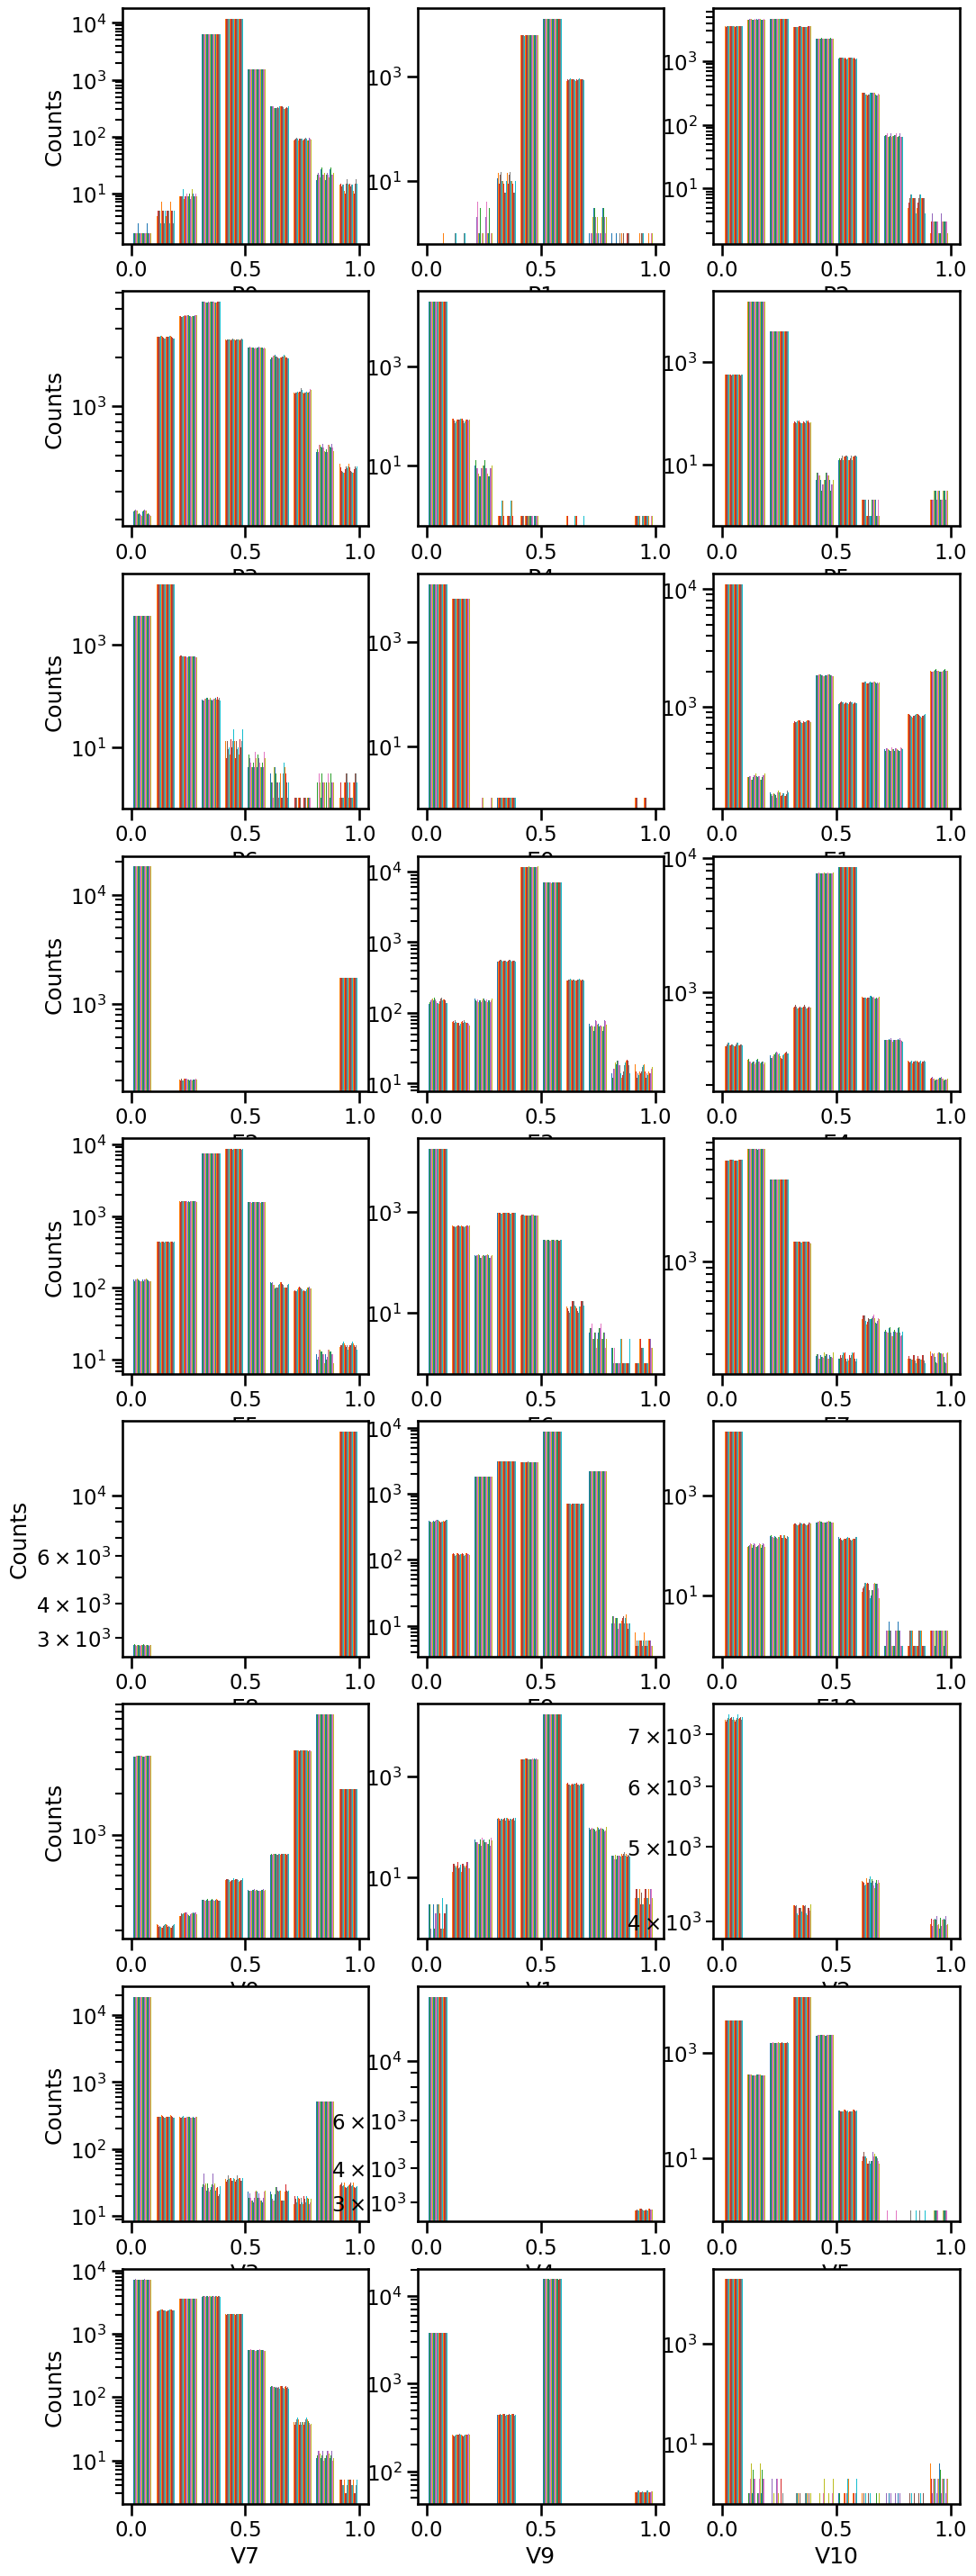

In [8]:
fig, axes = plt.subplots(9,3,figsize=(12,4*9))  
axes = axes.flatten()

for i, ax in enumerate(axes):
    x= norm_features[:,:,i]
    ax.hist(x=x)
    ax.set_yscale('log')
    ax.set_xlabel(names[i])
    if i%3 ==0:
        ax.set_ylabel('Counts')

### 2.4 Training Data Setup<a id='training_data'></a> 

In [9]:

features=norm_features[:]
labels=labels[:]
num_samples = 20000

# Convert to torch.tensor
X_ = torch.tensor(features, dtype=torch.float)
y_ = torch.tensor(labels, dtype=torch.float)

X= X_[:num_samples]
y= y_[:num_samples]
# Split using train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)


## 3. Time Series Classification<a id='tsc'></a> 

*Time series classification* (TSC) is a central problem in machine learning, with applications spanning a wide range of domains such as healthcare (e.g., electrocardiogram signal analysis), finance (e.g., stock price prediction), environmental monitoring (e.g., weather and climate forecasting), and industrial systems (e.g., fault detection and predictive maintenance). The goal of TSC is to assign a categorical label to a temporal sequence, where the ordering and temporal dependencies of data points carry critical information about the underlying process.

### 3.1 History of Time Series Classification<a id='traditional'></a> 

Historically, early research on time series classification was dominated by **distance-based** and **feature-based** methods. One of the most influential approaches is **Dynamic Time Warping (DTW)**, which aligns sequences of varying lengths by minimizing the temporal distortion required to match them. Variants such as 1-Nearest Neighbor with DTW and Derivative DTW became strong baselines for decades due to their simplicity and robustness. In parallel, **feature-based** techniques emerged, which transformed time series into fixed-length feature vectors using statistical summaries, frequency-domain representations, e.g., Fourier or wavelet transforms, or manually engineered descriptors. These features were then used with traditional classifiers such as **Support Vector Machines (SVMs), Random Forests**, or **k-Nearest Neighbors (k-NN)**.

While these classical approaches achieved competitive results on small and well-structured datasets, they heavily relied on domain expertise and handcrafted features. Moreover, they struggled to generalize across datasets with complex temporal dynamics, non-linear dependencies, and high-dimensional multivariate signals. As data volumes and complexity increased, the limitations of manual feature design and distance metrics became increasingly apparent.


### 3.2 Recent Deep Learning-based Approaches<a id='deep_learning'></a> 

The advent of **deep learning** marked a paradigm shift in time series analysis. Neural networks offered the ability to **learn hierarchical representations directly from raw data**, eliminating the need for handcrafted feature extraction. Among the most prominent architectures are **Recurrent Neural Networks** (RNNs), **Convolutional Neural Networks** (CNNs), and more recently, **Transformer-based encoders**. Each family of models offers distinct advantages for capturing temporal patterns and dependencies.

Early applications employed **RNNs**, particularly **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** networks, to capture sequential dependencies over time. These architectures introduced gating mechanisms to mitigate the vanishing gradient problem and model long-term temporal relationships effectively. However, RNN-based models often suffered from slow training, limited parallelization, and difficulties in capturing very long-range dependencies.

In parallel, **CNNs**, originally designed for computer vision, were adapted for one-dimensional time series data. CNN-based models exploit convolutional filters to detect local temporal patterns and compositional features. Architectures such as **ResNet** introduced residual connections, enabling deeper networks to be trained efficiently and improving representational capacity. These models proved particularly effective in capturing local structures and frequency-related features in both univariate and multivariate time series.

More recently, the **Transformer architecture**, first proposed for natural language processing, has gained traction in time series modeling. Unlike recurrent or convolutional models, Transformers rely on **self-attention mechanisms** to capture **global dependencies** between all time steps simultaneously. This allows them to model long-term temporal relationships more efficiently and with greater interpretability. The **Transformer encoder**, in particular, has demonstrated strong performance across various time series applications, benefiting from its scalability, parallelism, and ability to dynamically attend to relevant parts of the sequence.

## 4. Modeling<a id='modeling'></a> 

In this study, we explore and compare several deep learning architectures—LSTM, CNN/ResNet, and Transformer encoders—for multivariate time series classification. Our goal is to evaluate their capacity to model temporal dynamics, handle variable-length sequences, and generalize across diverse time series datasets. By analyzing their strengths and limitations, we aim to provide practical insights into the selection and design of deep architectures for time series classification tasks.

In [10]:
from parameters import Params
from Trainer import *
import os
os.makedirs('./output', exist_ok=True)

In [11]:
def read_metrics_model(trainacc, validacc, hyperpars, fnamehead):
    for i, par in enumerate(hyperpars):
        file = fnamehead+str(par)+'.json'
        with open(file, 'r') as f:
            data = json.load(f)
        #print(data)
        train_acc.append([ acc for acc in data['accuracy']['train']])
        valid_acc.append([ acc for acc in data['accuracy']['valid']])

def read_metrics_training(trainacc, validacc, lrs, sizes, modelname):
    for i, lr in enumerate(lrs):
        train_acc_temp =[]
        valid_acc_temp =[]
        for j, size in enumerate(sizes):
            file = './output/'+modelname+'_metrics_batchsize'+str(size)+'_lr'+str(lr)+'.json'
            with open(file, 'r') as f:
                data = json.load(f)
            #print(data)
            train_acc_temp.append([ acc for acc in data['accuracy']['train']])
            valid_acc_temp.append([ acc for acc in data['accuracy']['valid']])
        train_acc.append(train_acc_temp)
        valid_acc.append(valid_acc_temp)

In [12]:

def plot_metrics_model(nepochs, hyperpars, trainacc, validacc, label):
    epochs= [i+1 for i in range(nepochs)]
    ticks = [i+1 for i in range(nepochs) if (i+1)%2==0]
    
    fig, ax = plt.subplots(2,1, figsize=(10,10))
    for i in range(len(hyperpars)):
        sns.lineplot(x=epochs, y=trainacc[i], label=label+ f'{hyperpars[i]}', ax=ax[0])
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Train Accuracy")
    ax[0].set_title("Train Accuracy ")
    ax[0].set_ylim([0.8,1.0])
    ax[0].set_xticks(ticks) 
    ax[0].grid(True)

    for i in range(len(hyperpars)):
        sns.lineplot(x=epochs, y=validacc[i], label=label+ f'{hyperpars[i]}', ax=ax[1])
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Validation Accuracy")
    ax[1].set_title("Validation Accuracy ")
    ax[1].set_ylim([0.7,1.0])
    ax[1].legend(loc='upper left')
    ax[1].set_xticks(ticks) 
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()
    return fig


def plot_metrics_training(nepochs, lrs, sizes, trainacc, validacc, title):
    epochs= [i+1 for i in range(nepochs)]
    ticks = [i+1 for i in range(nepochs) if (i+1)%2==0]  
    
    plt.figure(figsize=(10,6))
    for i in range(len(lrs)):
        for j in range(len(sizes)):
            sns.lineplot(x=epochs, y=train_acc[i][j], label=f'learning rate {learning_rates[i]}, batch size {batch_sizes[j]}')
    plt.xlabel("Epoch")
    plt.ylabel("Train Accuracy")
    plt.title(title + 'Train Accuracy')
    plt.ylim([0.8,1.0])
    plt.xticks(ticks) 
    plt.grid(True)
    plt.savefig(title[:-2]+'_train.png')
    plt.show()

    plt.figure(figsize=(10,6))
    for i in range(len(learning_rates)):
        for j in range(len(batch_sizes)):
            sns.lineplot(x=epochs, y=valid_acc[i][j], label=f'learning rate {learning_rates[i]}, batch size {batch_sizes[j]}')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(title+ "Validation Accuracy")
    plt.ylim([0.7,1.0])
    plt.xticks(ticks) 
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.savefig(title[:-2]+'_val.png')
    plt.show()

### 4.1 LSTM Timeseries Classifier<a id='lstm'></a> 

LSTM networks were among the first deep architectures to demonstrate strong performance on sequential data.We use a single LSTM layer implemented in PyTorch and vary the number of hidden units to optimize performance.

In [13]:
params = Params()
params.model_name = 'LSTMClassifier'
params.checkpoint_frequency = 10000
params.seq_len = 40
params.num_features = 27
params.num_classes = 2
params.num_layers = 1
params.dropout = 0.3 # 0.3
params.batch_size = 32 # 32 
params.learning_rate =0.001 # 0.001
params.n_epochs = 20 # 1 for test
params.hidden_dim = 128

def train_rnn_model(pars, metrics_path, model_path=None):
    res = LSTMClassifier(input_dim=27, hidden_dim=pars.hidden_dim, 
                         num_layers=pars.num_layers, num_classes=2, dropout=pars.dropout, bidirectional=True)
    optimizer = torch.optim.AdamW(res.parameters(), lr=pars.learning_rate)
    trainer = Trainer(
        model=res,
        params=pars,
        optimizer=optimizer,
        train_iter=train_dataset,
        valid_iter=val_dataset,
        debug = 0
    )
    trainer.metrics_path = metrics_path 
    trainer.model_path = model_path
    trainer.train()
    if model_path != None:
        trainer.save_model()    

In [14]:
hidden_dims=[64,128,256]
for h in hidden_dims:
    params.hidden_dim = h
    pmetrics = './output/rnn_metrics_hiddendim'+ str(h) +'.json'
    #train_rnn_model(params, pmetrics)

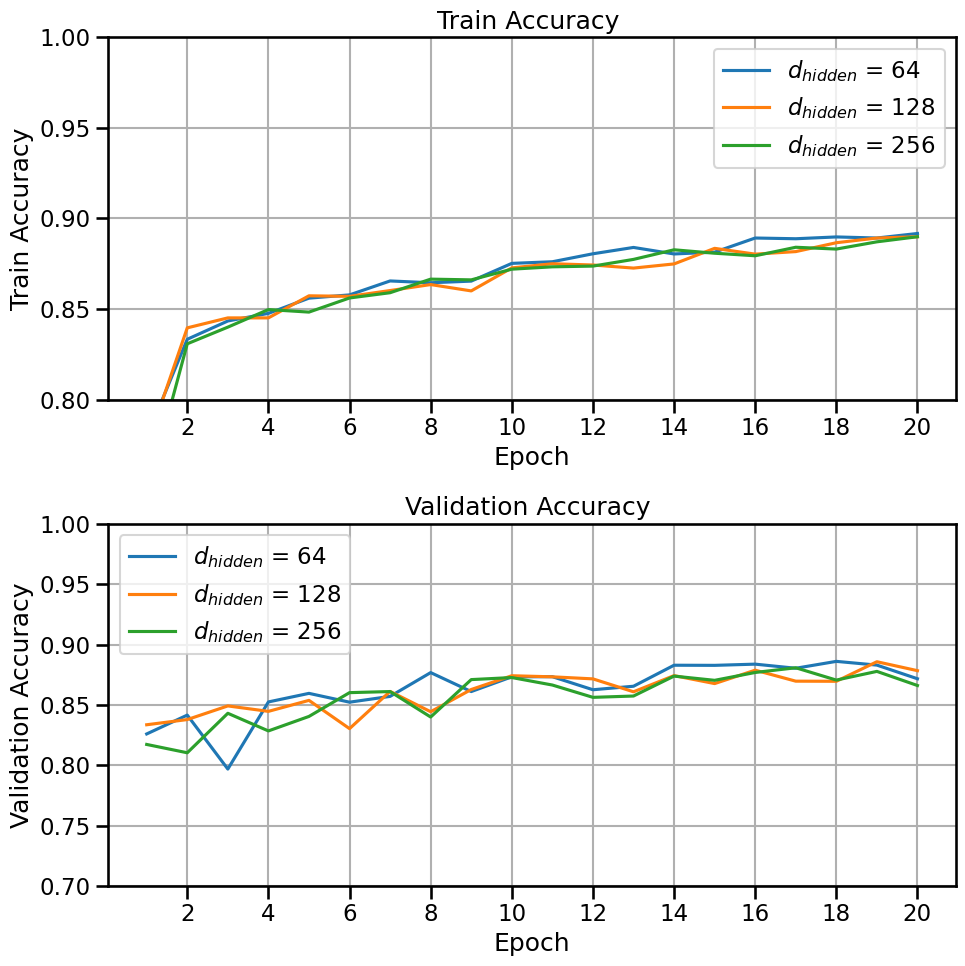

In [15]:
train_acc = [] 
valid_acc = [] 
read_metrics_model(train_acc, valid_acc, hidden_dims,'output/rnn_metrics_hiddendim')
fig = plot_metrics_model(params.n_epochs, hidden_dims , train_acc, valid_acc, r'$d_{hidden}$ = ')
fig.savefig('dim_hidden.png')

No strong dependence on the hidden dimension was observed.

In [16]:
params.dropout = 0.3 # 0.3
params.hidden_dim = 128
params.n_epochs = 100 
pmetrics = './output/rnn_metrics.json'
pmodel = './output/rnn_model.pt'
os.makedirs('./output/rnn', exist_ok=True)
params.checkpoint_dir = './output/rnn'
params.checkpoint_frequency = 10
#train_rnn_model(params, pmetrics, pmodel)

### 4.2 CNN/ResNet Timeseries Classifier<a id='cnn'></a> 

ResNet models extract local temporal features and hierarchical representations through one-dimensional convolutions. The inclusion of residual connections improves gradient flow and facilitates the training of deep networks, allowing the model to learn both low- and high-level temporal patterns efficiently.

In [17]:
params = Params()
params.model_name = 'ResNetClassifier'
params.checkpoint_frequency = 10000
params.seq_len = 40
params.num_features = 27
params.num_classes = 2
params.fmult = 2 
params.batch_size = 128 
params.learning_rate = 0.01 
params.n_epochs = 20 # 1 for test

def train_cnn_model(pars, metrics_path, model_path=None):
    res = ResNetClassifier(input_channels=pars.num_features, mult_out_channel=params.fmult)
    optimizer = torch.optim.AdamW(res.parameters(), lr=pars.learning_rate)
    trainer = Trainer(
        model=res,
        params=pars,
        optimizer=optimizer,
        train_iter=train_dataset,
        valid_iter=val_dataset,
        debug = 0
    )
    trainer.metrics_path = metrics_path 
    trainer.model_path = model_path
    trainer.train()
    if model_path != None:
        trainer.save_model()

#### 4.2.1 Network Size $f_{mult}$ <a id='cnn_network_size'></a> 

There are three ResNet layers in the model architecture, where the output size of each layer doubles that of the previous one. This design increases the model’s capacity to compensate for the loss of spatial or temporal resolution. The output size of the first layer is set to $f_{mult} \times$ num_features. The following values are used to determine the optimal factor.

In [18]:
mult_factors = [1,2,3]
for mul in mult_factors:
    params.fmult = mul 
    pmetrics = './output/cnn_metrics_mult'+ str(mul) +'.json'
    #train_cnn_model(params, pmetrics)

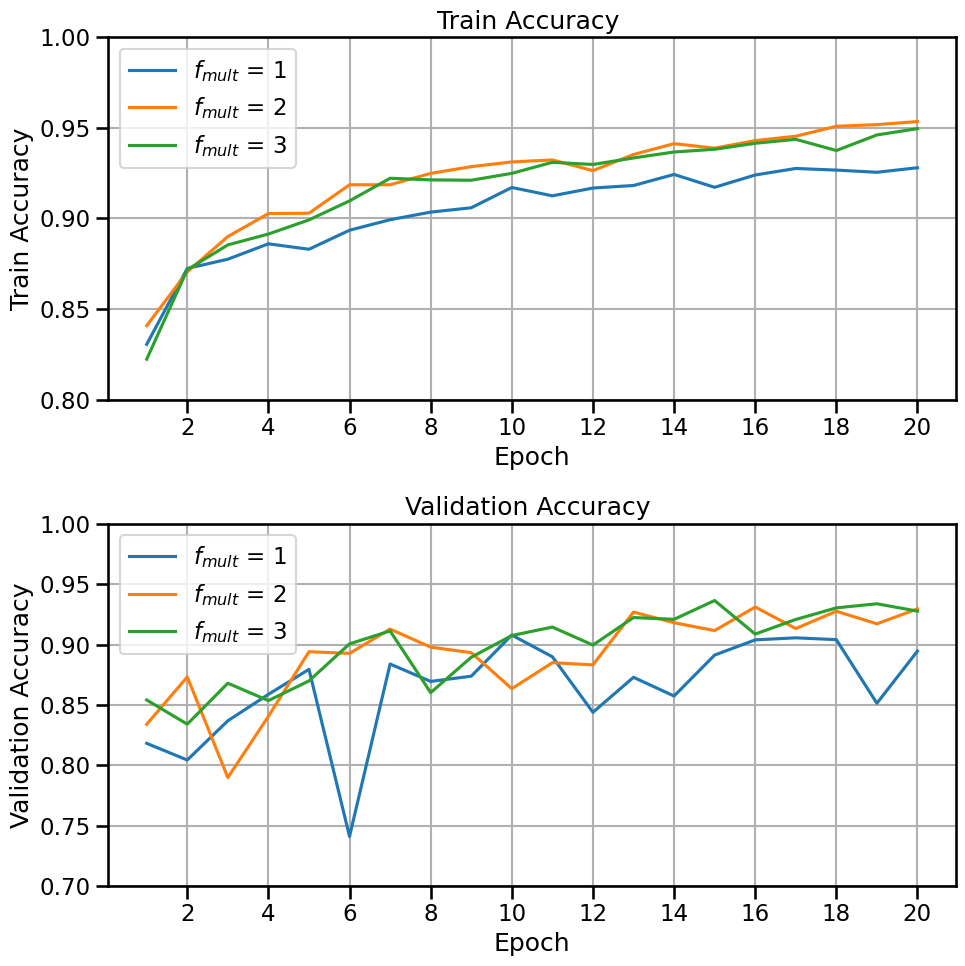

In [19]:
train_acc = [] 
valid_acc = [] 
read_metrics_model(train_acc, valid_acc, mult_factors,'output/cnn_metrics_mult')
fig = plot_metrics_model(params.n_epochs, mult_factors, train_acc, valid_acc, r'$f_{mult}$ = ')
fig.savefig('network_size.png')

#### 4.2.2 Training Hyperparameter Tuning<a id='cnn_hyperparameters'></a> 

In [20]:
batch_sizes=[64, 128, 256]
learning_rates = [0.001, 0.01]

for lr in learning_rates:
    for size in batch_sizes:
        params.fmult = 2
        params.batch_size = size
        params.learning_rate = lr
        pmetrics = './output/cnn_metrics_batchsize'+ str(size)+'_lr'+str(lr)+'.json'
        #train_cnn_model(params, pmetrics)

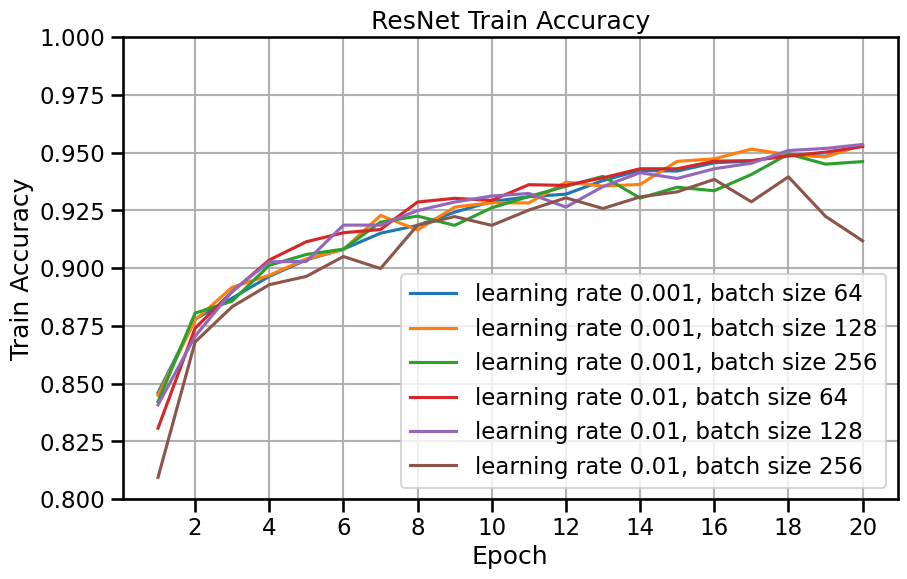

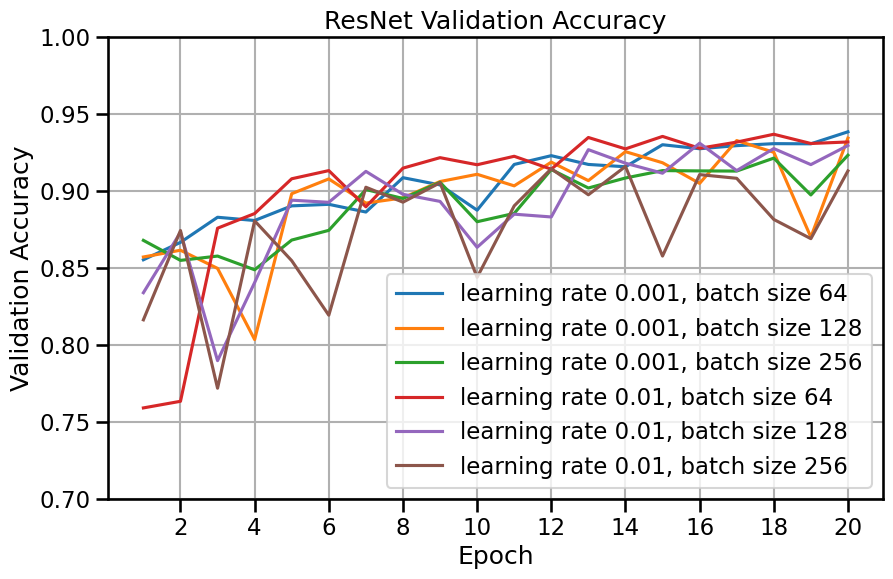

In [21]:
train_acc = [] 
valid_acc = [] 
read_metrics_training(train_acc, valid_acc, learning_rates,batch_sizes, 'cnn')
plot_metrics_training(params.n_epochs, learning_rates, batch_sizes, train_acc, valid_acc, 'ResNet ')

**Conclusion** A batch size of 64 and a learning rate of 0.001- 0.01, combined with an $f_{mult}$ value of 2, were found to yield optimal performance.

In [22]:
params.fmult = 2
params.batch_size = 64
params.learning_rate = 0.01
params.n_epochs = 100
pmetrics = './output/cnn_metrics.json'
pmodel = './output/cnn_model.pt'
os.makedirs('./output/cnn', exist_ok=True)
params.checkpoint_dir = './output/cnn'
params.checkpoint_frequency = 10
#train_cnn_model(params, pmetrics, pmodel)

### 4.3 Transformer Timeseries Classifier<a id='transformer'></a> 

A Transformer encoder classifier leverages self-attention mechanisms to capture complex temporal and contextual relationships within input sequences. It encodes the data into a latent representation through stacked encoder layers, followed by a classification head that predicts the target class based on the aggregated embeddings. In this work, a single Transformer encoder layer is utilized, consisting of embedding, multi-head self-attention, and position-wise feed-forward sublayers, integrated via residual connections and layer normalization.

In [23]:
params = Params()
params.model_name = 'SelfAttentionEncoderClassifier'
params.seq_len = 40
params.num_features = 27
params.num_classes = 2
params.checkpoint_frequency = 10000
params.num_layers = 1
params.num_heads=4
params.dim_embed = 128
params.dim_ff = params.dim_embed * 8
params.learning_rate = 0.001
params.batch_size = 16
params.n_epochs = 50 # 1 for test
params.dropout = 0.4
params.embedding = 1 # 0: FullFeatureTemporalEmbedding, 1: FeatureLinearProjectionTemporalEmbedding

def train_encoder_model(pars, metrics_path, model_path=None):
    ttc = SelfAttentionEncoderClassifier(pars)
    optimizer = torch.optim.AdamW(ttc.parameters(), lr=pars.learning_rate)
    trainer = Trainer(
        model=ttc,
        params=params,
        optimizer=optimizer,
        train_iter=train_dataset,
        valid_iter=val_dataset,
        debug = 0
    )
    trainer.metrics_path = metrics_path 
    trainer.model_path = model_path
    trainer.train()
    if model_path != None:
        trainer.save_model()

#### 4.3.1 Training Hyperparameter Tuning<a id='encoder_hyperparameters'></a> 

In [24]:
batch_sizes = [16,32]
learning_rates = [0.0001, 0.001]

for lr in learning_rates:
    for size in batch_sizes:
        params.batch_size = size
        params.learning_rate = lr
        pmetrics = './output/encoder_metrics_batchsize'+ str(size)+'_lr'+str(lr)+'.json'
        #train_encoder_model(params, pmetrics)

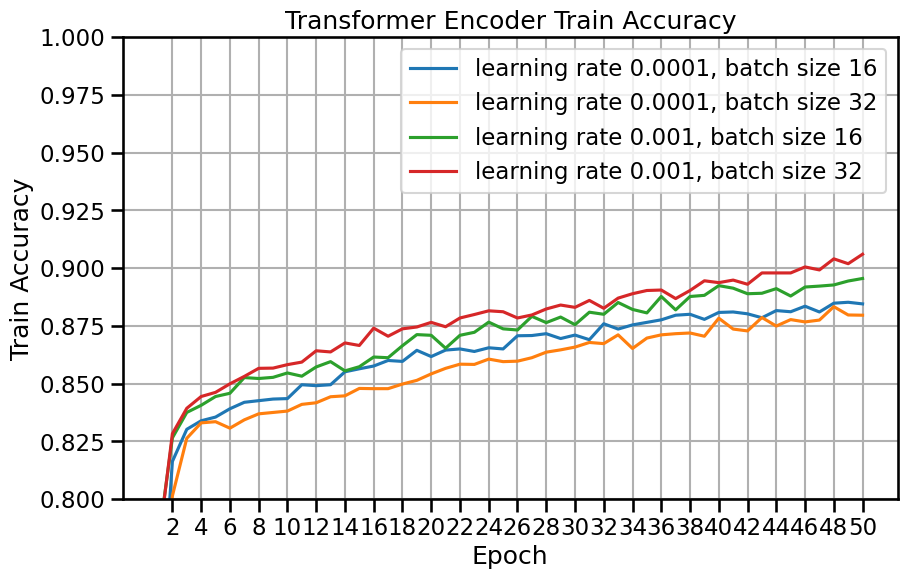

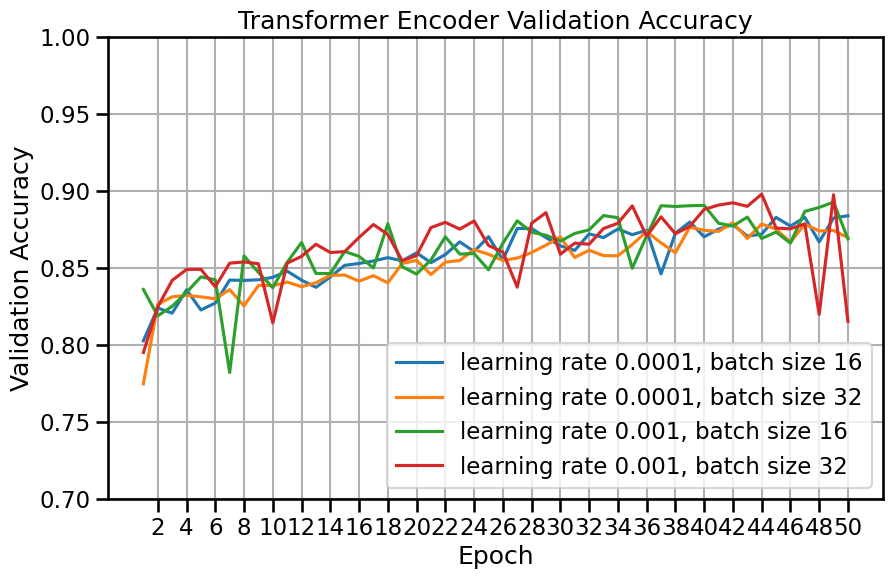

In [25]:
train_acc = [] 
valid_acc = [] 
read_metrics_training(train_acc, valid_acc, learning_rates,batch_sizes, 'encoder')
plot_metrics_training(params.n_epochs, learning_rates, batch_sizes, train_acc, valid_acc, 'Transformer Encoder ')

We choose a learning rate of 0.001 and a batch size of 32. 

#### 4.3.2 Embeddings<a id='embeddings'></a> 

Two alternative embedding strategies were investigated. In the first approach, both the full feature embeddings and temporal embeddings were added to the linearly projected feature representations. While this method provided a comprehensive joint embedding space, it was computationally expensive and inefficient for the given dataset. In contrast, a more effective approach involved applying a linear projection to the feature vectors and subsequently incorporating only the temporal embedding components, resulting in a more efficient and scalable representation.

Several embedding dimensions were explored to identify the most effective configuration.

In [26]:
embed_dims =[64,128,256,512] 
for dim in embed_dims:
    params.dim_embed = dim
    params.learning_rate = 0.001
    params.batch_size = 32
    pmetrics = './output/encoder_metrics_dimemb'+ str(dim) +'.json'
    #train_encoder_model(params, pmetrics)

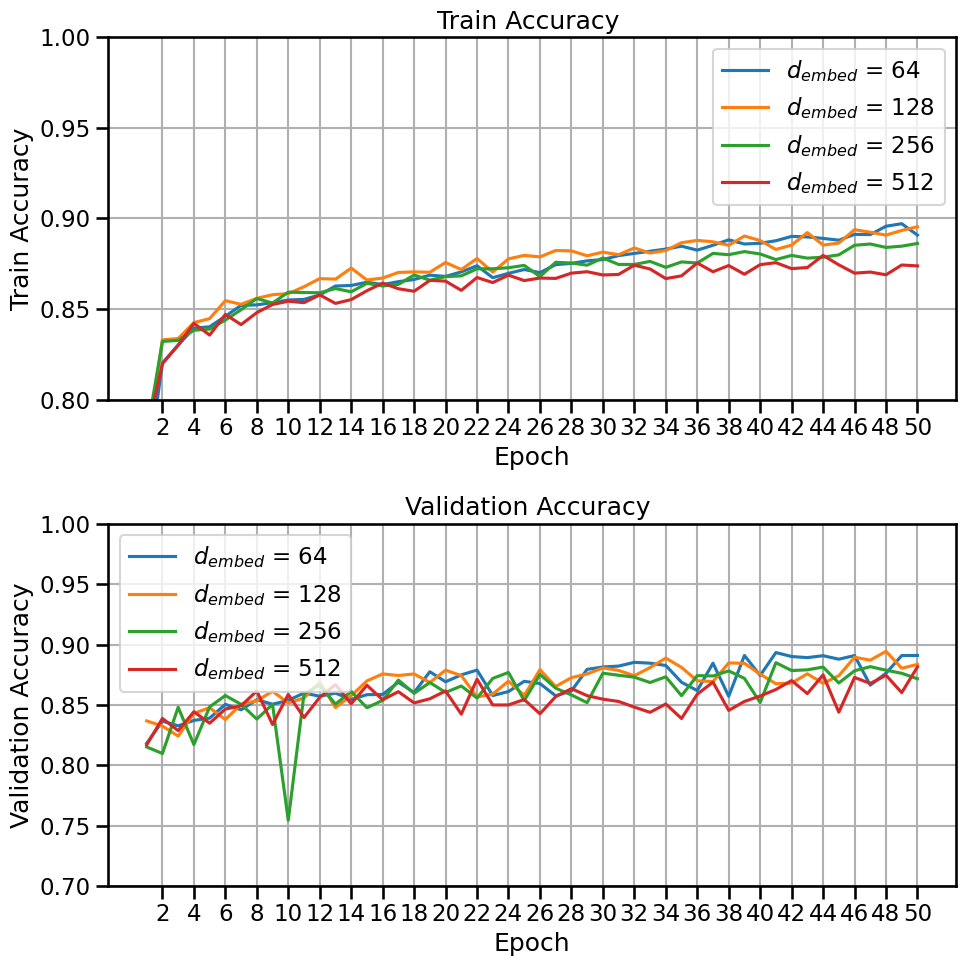

In [27]:
train_acc = [] 
valid_acc = [] 
read_metrics_model(train_acc, valid_acc, embed_dims,'output/encoder_metrics_dimemb')
fig = plot_metrics_model(params.n_epochs, embed_dims , train_acc, valid_acc, r'$d_{embed}$ = ')
fig.savefig('dim_embed.png')

#### 4.3.3 Multi-headed Self-attention Mechanisms<a id='self-attention'></a> 

The self-attention framework enables the model to weigh the relative importance of different time steps dynamically, making it well suited for complex multivariate time series with intricate interdependencies between features. The number of attention heads determines how the model distributes its representational capacity across different subspaces of the embedding. Consequently, the embedding dimension must be a multiple of the number of heads to allow an even partitioning of the embedding vector across all attention heads. 

In [28]:
nheads= [4,8,16]
for n in nheads:
    params.dim_embed = 128
    params.learning_rate = 0.001
    params.batch_size = 32
    
    params.num_heads = n
    pmetrics = './output/encoder_metrics_nheads'+ str(n) +'.json'
    #train_encoder_model(params, pmetrics)

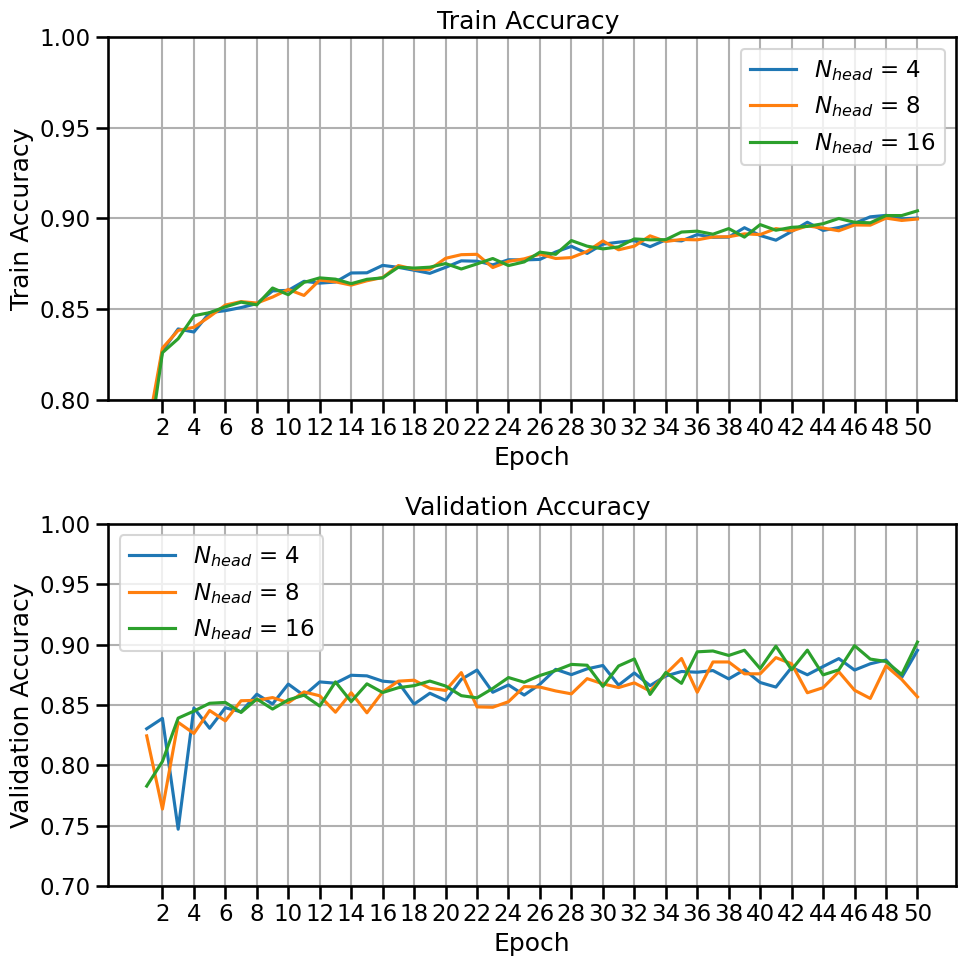

In [29]:
train_acc = [] 
valid_acc = [] 
read_metrics_model(train_acc, valid_acc, nheads,'output/encoder_metrics_nheads')
fig = plot_metrics_model(params.n_epochs, nheads , train_acc, valid_acc, r'$N_{head}$ = ')
fig.savefig('nhead.png')

We choolse $N_{head}$ of 4 and $d_{embed}$ of 128.

#### 4.3.4 Feed Forward Network and Residual Connections<a id='ff_res'></a> 

While Transformer encoders can consist of multiple stacked layers, our implementation utilizes a single encoder layer for efficiency and simplicity, $n_{layers} = 1$.
In each Transformer encoder block, after the multi-head self-attention, there’s a position-wise feed-forward network (FFN).
In almost all Transformer architectures $d_{ff} = 4\times d_{embed}$. The self-attention layer mixes information across time steps. The feed-forward network expands this information within each time step, i.e., it gives the model non-linear capacity to represent more complex transformations. A larger $d_{ff}$ increases model capacity, but also computation and memory. We evaluate the model’s performance using the following parameter values.

In [30]:
ff_dim_mults = [4,6,8]

for f in ff_dim_mults:
    params.dim_embed = 128 #dim
    params.num_heads = 4 #n
    params.ff_dim = f * params.dim_embed
    pmetrics = './output/encoder_metrics_dimff'+ str(f) +'.json'
    #train_encoder_model(params, pmetrics)

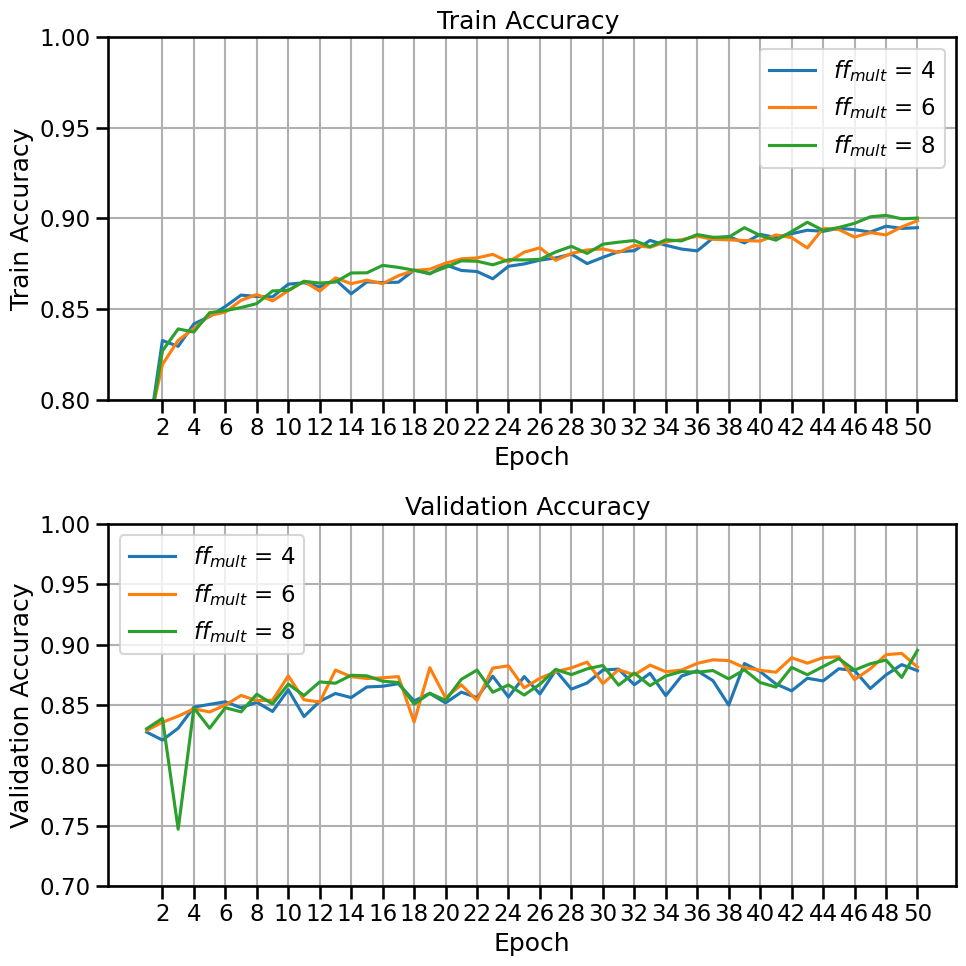

In [31]:
train_acc = [] 
valid_acc = [] 
read_metrics_model(train_acc, valid_acc, ff_dim_mults,'output/encoder_metrics_dimff')
fig = plot_metrics_model(params.n_epochs, ff_dim_mults , train_acc, valid_acc, r'$ff_{mult}$ = ')
fig.savefig('ff_mult.png')

We select $ff_{mult}$ of 6.

#### 4.3.5 Drop-out Rate<a id='encoder_dropout'></a> 

In [32]:
dropouts = [0.1,0.2,0.3,0.4]
for r in dropouts:
    params.dim_embed = 128 #dim
    params.num_heads = 4 #n
    params.ff_dim = 6 * params.dim_embed
    params.dropout = r
    pmetrics = './output/encoder_metrics_dropout'+ str(r) +'.json'
    #train_encoder_model(params, pmetrics)

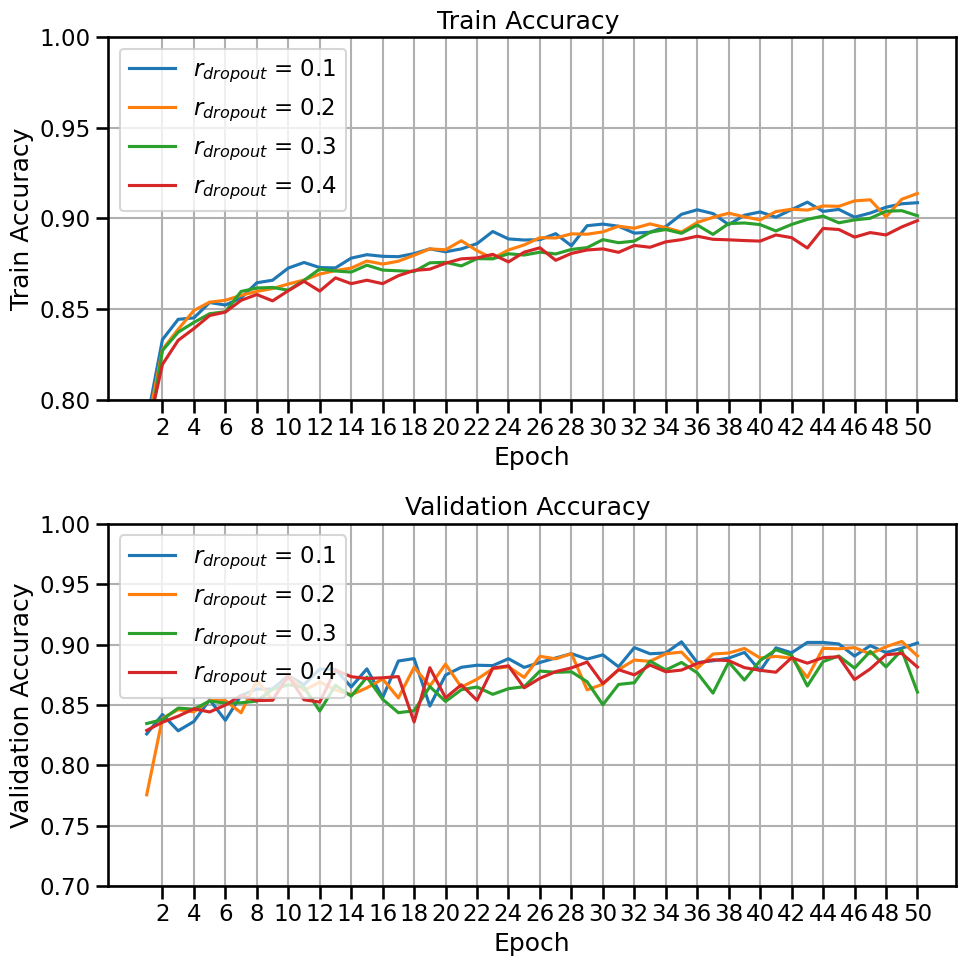

In [33]:
train_acc = [] 
valid_acc = [] 
read_metrics_model(train_acc, valid_acc, dropouts,'output/encoder_metrics_dropout')
fig = plot_metrics_model(params.n_epochs, dropouts , train_acc, valid_acc, r'$r_{dropout}$ = ')
fig.savefig('dropout.png')

The dropout rate appears to be the most influential hyperparameter affecting training quality. We also observe that the encoder model continues to improve in performance up to 50 epochs, suggesting that it requires a larger number of training epochs to reach optimal performance.

In [34]:
params.dim_embed = 128 #dim
params.num_heads = 4 #n
params.ff_dim = 6 * params.dim_embed
params.dropout = 0.1
params.n_epochs = 200
pmetrics = './output/encoder_metrics.json'
pmodel = './output/encoder_model.pt'
os.makedirs('./output/encoder', exist_ok=True)
params.checkpoint_dir = './output/encoder'
params.checkpoint_frequency = 10
#train_encoder_model(params, pmetrics)

#### 4.3.6 Feature Importance<a id='encoder_feature_importance'></a> 

We compute the feature importance using probability-based gradients, which are averaged over all time steps.

In [35]:
file_path = './output/encoder/checkpoint_170.pt'

model = torch.load(file_path, map_location=torch.device('cpu'))
optimizer = torch.optim.AdamW(model.parameters(), lr=params.learning_rate)

trainer = Trainer(
        model=model,
        params=params,
        optimizer=optimizer,
        train_iter=train_dataset,
        valid_iter=val_dataset,
        debug = 0
)

In [36]:
saliency = trainer.compute_feature_importance(X_val[:50])
feature_importance = saliency.mean(dim=0)  # (batch, num_features)
feature_importance /= (feature_importance.max(dim=0, keepdim=True)[0] + 1e-8)
feature_importance

tensor([0.0461, 0.0133, 0.0184, 0.0197, 0.0865, 0.1489, 0.1399, 0.0568, 0.0658,
        0.0521, 0.0318, 0.0470, 0.0545, 0.1051, 0.0916, 0.0399, 0.1039, 0.0444,
        0.0456, 0.0246, 0.0551, 0.0613, 0.0209, 0.0255, 0.0252, 0.0262, 1.0000])

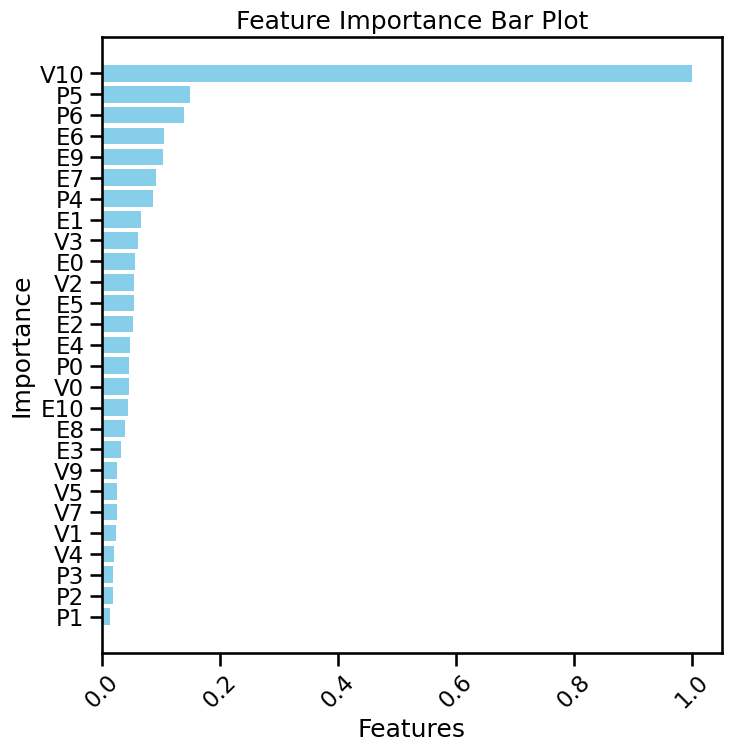

In [37]:
fea_imp = {}
for i, name in enumerate(names):
    fea_imp[name] =  feature_importance[i].item()

sorted_fea_imp = dict(sorted(fea_imp.items(), key=lambda item: item[1], reverse=False))
features = list(sorted_fea_imp.keys())
importances = list(sorted_fea_imp.values())

# Create bar plot
plt.figure(figsize=(8,8))
plt.barh(features,importances,color='skyblue')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance Bar Plot")
plt.xticks(rotation=45)
plt.savefig('feature_importance.png')
plt.show()

The most important feature is **V10**, which showed clear differences between distracted and alert drivers in <a href="https://github.com/sookhyun/Multimodal-Transformer-Classifier_Distracted_Driver_Detection/blob/main/%5Bnb%5DObjectives_and_Data_Exploration.ipynb" target="_blank">this notebook.</a> The next few most important features are physiological, **P5** and **P6**, which is reasonable since distraction reflects both mental and physical states.

## 5. Results<a id='results'></a> 

### 5.1 Evaulation metrics<a id='metrics'></a> 

We evaluate the models using Recall, Precision, and the AUC–ROC curve, which provide insights into model performance on our imbalanced dataset. We also save the validation data associated with the saved models for later result visualization.

In [38]:
update_file = False
if update_file == True:
    torch.save(
        {
            'X_val': X_val,   # feature tensor
            'y_val': y_val    # label tensor
        },
        'validation_data.pth'
    )

In [39]:
data = torch.load('validation_data.pth', map_location=torch.device('cpu'))

X_val = data['X_val']
y_val = data['y_val']

### 5.2 Performance Comparison of Models<a id='comparisons'></a> 

In [40]:
def evaluate_model(file_path, model_name):
# Load the entire model
    model = torch.load(file_path, map_location=torch.device('cpu'))

    # Set the model to evaluation mode
    model.eval()

    y_true = []
    y_score = []
    y_pred = []

    with torch.no_grad():
        outputs = model(X_val)
        probs = torch.sigmoid(outputs).squeeze()  # for binary classification
        preds = (probs >= 0.5).int()   
        
        y_true.extend(y_val.cpu().numpy())
        y_score.extend(probs.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    
    auc = roc_auc_score(y_true, y_score)
    print(f"AUC: {auc:.4f}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}")


    fpr, tpr, _ = roc_curve(y_true, y_score)

    plt.plot(fpr, tpr, label=f"Precision: {precision:.3f}\n Recall: {recall:.3f} \n AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for "+model_name)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(model_name+'.png')
    plt.show()

    return fpr, tpr, auc 


In [41]:
rnn_path = './output/rnn/checkpoint_100.pt'
cnn_path = './output/cnn/checkpoint_100.pt'
encoder_path = './output/encoder/checkpoint_170.pt'

AUC: 0.9411
Precision: 0.884, Recall: 0.947


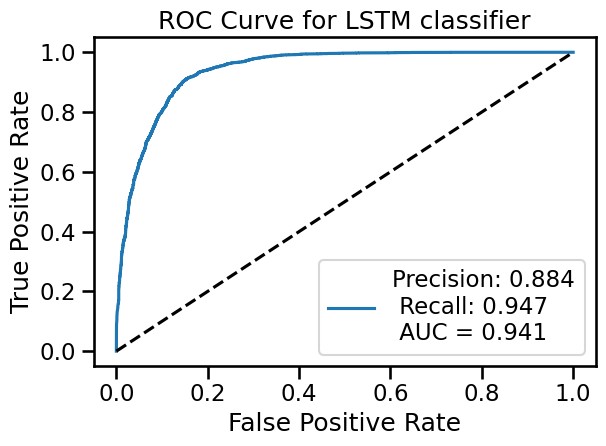

In [42]:
fpr_rnn, tpr_rnn, auc_rnn = evaluate_model(rnn_path, 'LSTM classifier')

AUC: 0.9772
Precision: 0.959, Recall: 0.944


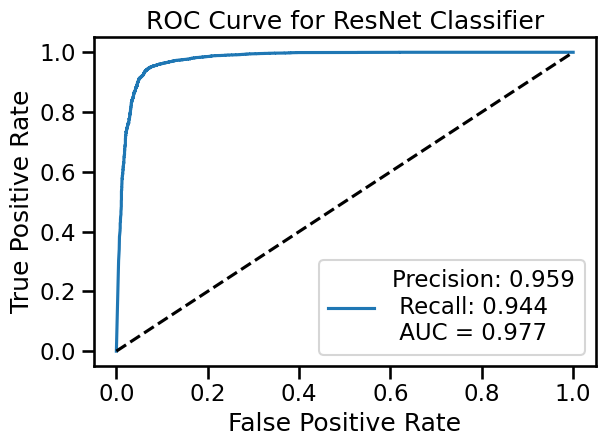

In [43]:
fpr_cnn, tpr_cnn, auc_cnn = evaluate_model(cnn_path,'ResNet Classifier')

AUC: 0.9588
Precision: 0.925, Recall: 0.948


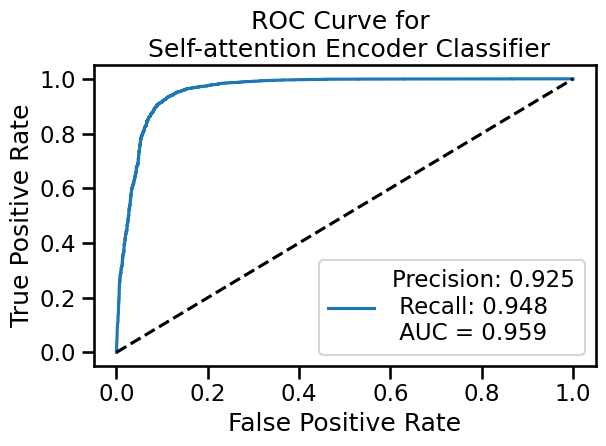

In [44]:
fpr_enc, tpr_enc, auc_enc = evaluate_model(encoder_path, '\n Self-attention Encoder Classifier')

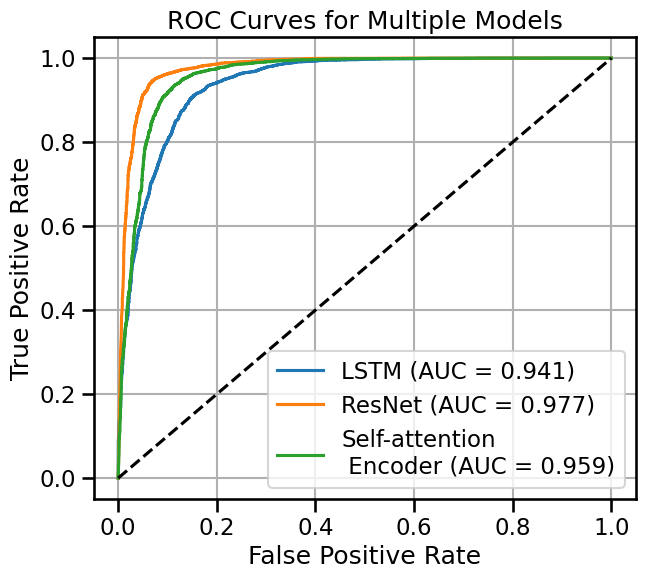

In [45]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_rnn, tpr_rnn, label=f"LSTM (AUC = {auc_rnn:.3f})")
plt.plot(fpr_cnn, tpr_cnn, label=f"ResNet (AUC = {auc_cnn:.3f})")
plt.plot(fpr_enc, tpr_enc, label=f"Self-attention\n Encoder (AUC = {auc_enc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multiple Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('comparison.png')
plt.show()

## 6. Conclusion<a id='conclusion'></a> 

By **recall**, a safety-critical metric since missing a distracted driver is costly, the **self-attention encoder** performs best, while other models trail closely. In contrast, the **ResNet** model achieves the highest **precision**, helping to reduce over-alerting, and shows the best overall performance by **AUC**. Both models’ strengths can be explained by their architectures: **ResNet** excels at hierarchical spatial feature learning, enabling it to capture detailed spatial patterns, whereas the **self-attention encoder** effectively captures long-range dependencies and contextual relationships. Together, these characteristics account for their superior performance in detecting distracted versus alert drivers.
